<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Building Models for Accuracy vs. Speed

This notebook analyses how various parameters influence model accuracy and inference speed. For evaluation, the popular [**COCO**](http://cocodataset.org/#home) dataset is used so that our numbers can be compared to published results. In addition, we show how to reproduce the accuracy of Torchvision's pre-trained Faster R-CNN model reported on their [models](https://pytorch.org/docs/stable/torchvision/models.html) site.

Familiarity with the [01_training_introduction.ipynb](01_training_introduction.ipynb) notebook is assumed, and hence no explanation for repeated concepts or code provided. Instead, we focus on new aspects such as how to evaluate on the COCO dataset, or how to improve speed and accuracy. Training a new model on the COCO dataset, while not covered in this notebook, could be easily added by copying the respective cells from the 01_training_introduction notebook.



## Initialization

Import all the functions we need.

In [1]:
import sys
sys.path.append("../../")
import os
import time
import matplotlib.pyplot as plt
from pathlib import Path
import scrapbook as sb
import torch
import torchvision

from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import is_windows, which_processor
from utils_cv.detection.data import coco_labels, Urls
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.plot import plot_pr_curves
from utils_cv.detection.model import _calculate_ap, DetectionLearner, get_pretrained_fasterrcnn

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0
('cudart64_100', 0)
Torch is using GPU: Tesla V100-PCIE-16GB


In [2]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Check if a GPU is present, since it is required by detector.evaluate().

In [3]:
assert torch.cuda.is_available()

---

# Prepare COCO Dataset

#### Download data

The COCO 2017 validation dataset is used in all our experiments following common practice for benchmarking object detection models. In particular, two `.zip` archives need to be downloaded from [http://cocodataset.org](http://cocodataset.org/#download): the actual images [2017 val images (1GB)](http://images.cocodataset.org/zips/val2017.zip) and the ground truth annotations [2017 train/val annotations (241MB)](http://images.cocodataset.org/annotations/annotations_trainval2017.zip).

The two files should be extracted and placed in a root-folder as shown below, with subfolders called *annotationsCOCO* and *images*:
```
/coco2017
+-- annotationsCOCO
|   +-- captions_train2017.json
|   +-- captions_val2017.json
|   +-- ...
+-- images
|   +-- 000000000139.jpg
|   +-- 000000000285.jpg
|   +-- ...
```


#### Convert COCO to VOC

The COCO dataset comes with annotations in its own format, see this [description](https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch/#coco-dataset-format). Hence, we need to convert the downloaded COCO annotations to Pascal VOC format in order to run this notebook. The function coco2voc does exactly that and only takes seconds to run. In the code below, we assume the COCO images and annotations are in the folder '/data/coco2017/'; the function then creates a new sub-directory called *annotations*. The function also, if activated, downloads the images provided their urls are specified in the `.json` file.


```python
from utils_cv.detection.data import coco2voc
coco2voc(
    anno_path = "/data/coco2017/annotationsCOCO/instances_val2017.json",
    output_dir = "/data/coco2017/",
    download_images = False
)
```

# Load Images

#### Path to data

The `DATA_PATH` variable should point to the COCO root directory which in the example above is `"/data/coco2017/"`.

In [4]:
# COCO dataset
DATA_PATH = "/data/coco2017/"
LABELS = coco_labels()[1:] #ignore first entry which is "__background__"

The `DATA_PATH` directory should contain the `annotations`, `images`, and (albeit not used) `annotationsCOCO` folders.


In [5]:
os.listdir(DATA_PATH)

['annotations', 'annotationsCOCO', 'images']

#### Data loading

Most code in this notebook is taken from [01_training_introduction.ipynb](01_training_introduction.ipynb) with only small changes, mainly to ensure the class names (and ordering) in the `DetectionDataset` object matches those used to train the Torchvision model. Hence, in the cell below, we explicitly provide `labels` as input to the detection dataset.

Note that:
- The `DetectionDataset` object requires at least 1 image to be assigned to the training set, hence we set `train_pct=0.0001`.
- The first element returned by `coco_labels()` is "\_\_background\_\_" and is removed when setting `LABELS = coco_labels()[1:]`.
- We set `allow_negatives = True` since a few of the COCO images don't contain any annotated objects and hence don't have a corresponding `.xml` annotation file.

In [6]:
data = DetectionDataset(DATA_PATH, 
                        train_pct=0.0001, 
                        labels = LABELS, 
                        allow_negatives = True)
                        #max_num_images = 100) # Uncomment to only use small subset of COCO
print(f"Number of test images: {len(data.test_ds)}")

Number of test images: 4999


The plots below summarize some aspects of the annotations, eg. the counts of ground truth boxes per class, or the distribution of absolute and relative widths/heights of the objects. 

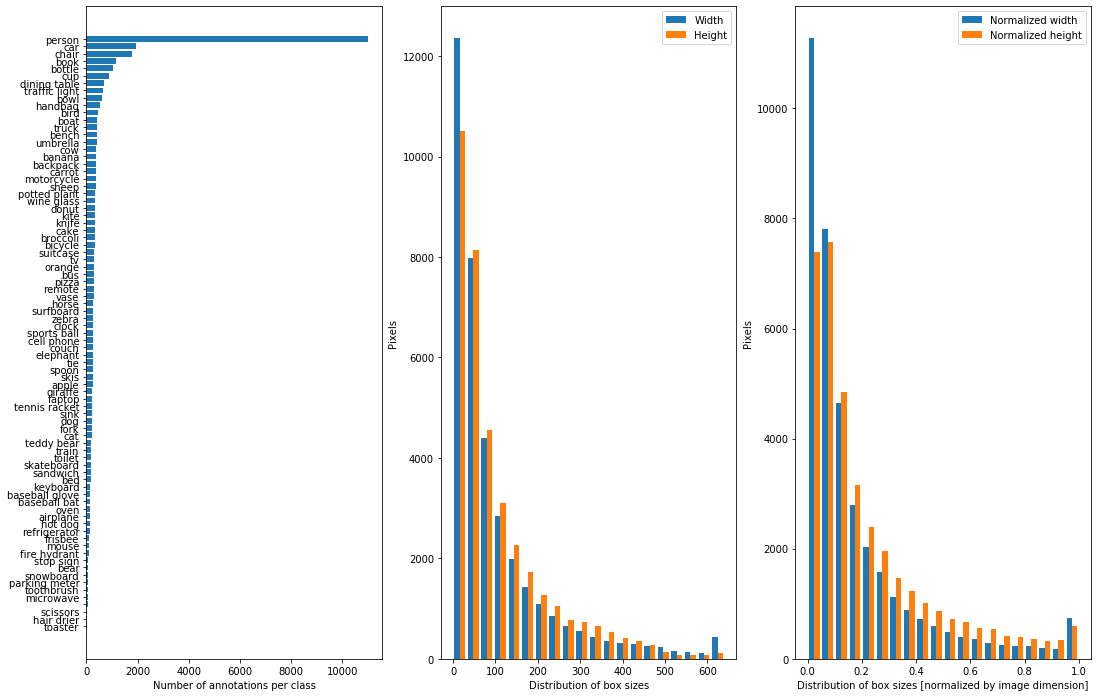

In [7]:
data.plot_boxes_stats(figsize = (18,12))

Lets visualize the annotations to make sure they look correct.

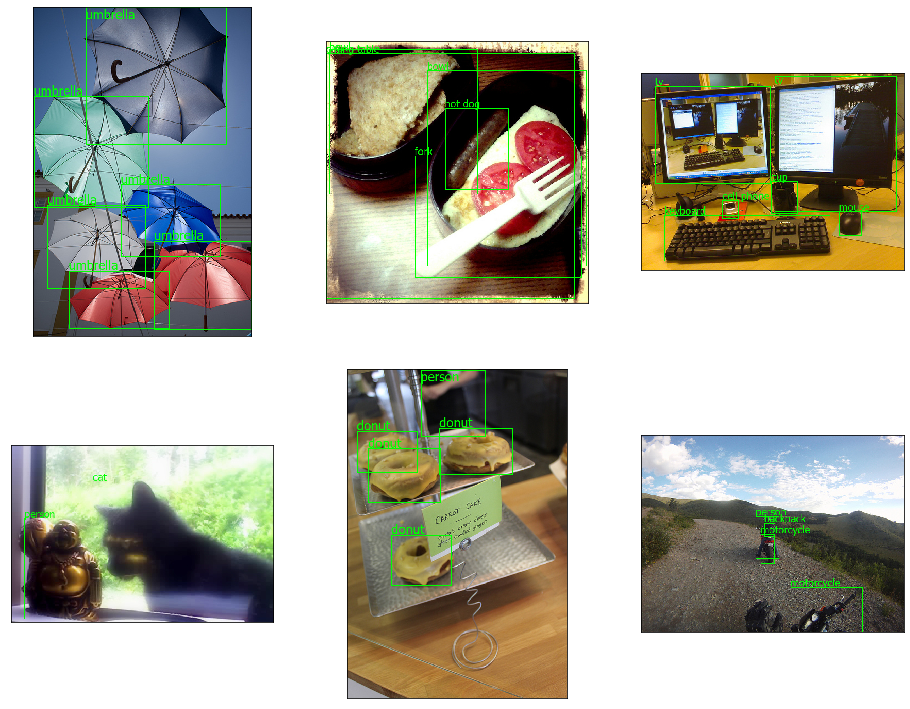

In [8]:
data.show_ims(rows=2)

# Reproduce reported accuracy

We now load the Faster-RCNN model (with [feature pyramid network](https://arxiv.org/pdf/1612.03144.pdf) extension) which was trained on COCO. In contrast to the [01_training_introduction.ipynb](01_training_introduction.ipynb) notebook, we do not create a new classification layer, but instead keep the existing last layer of the pre-trained model.

In [9]:
model = get_pretrained_fasterrcnn()
detector = DetectionLearner(data, model)
print(f"Model: {type(detector.model)}")

Model: <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


We can simply run the `evaluate()` method and observe that the mAP in the first row (for IoU=0.50:0.95) is close to the number reported on Torchvision's [models](https://pytorch.org/docs/stable/torchvision/models.html) site.

In [10]:
e = detector.evaluate()

creating index...
index created!
Test:  [   0/2500]  eta: 1:30:35  model_time: 2.1428 (2.1428)  evaluator_time: 0.0156 (0.0156)  time: 2.1741  data: 0.0156  max mem: 982
Test:  [ 100/2500]  eta: 0:06:05  model_time: 0.0781 (0.1097)  evaluator_time: 0.0156 (0.0174)  time: 0.1345  data: 0.0234  max mem: 1662
Test:  [ 200/2500]  eta: 0:05:25  model_time: 0.0781 (0.0993)  evaluator_time: 0.0156 (0.0165)  time: 0.1283  data: 0.0242  max mem: 1709
Test:  [ 300/2500]  eta: 0:04:59  model_time: 0.0792 (0.0947)  evaluator_time: 0.0156 (0.0157)  time: 0.1275  data: 0.0250  max mem: 1730
Test:  [ 400/2500]  eta: 0:04:42  model_time: 0.0781 (0.0929)  evaluator_time: 0.0156 (0.0160)  time: 0.1306  data: 0.0242  max mem: 1749
Test:  [ 500/2500]  eta: 0:04:25  model_time: 0.0781 (0.0915)  evaluator_time: 0.0156 (0.0162)  time: 0.1259  data: 0.0242  max mem: 1763
Test:  [ 600/2500]  eta: 0:04:11  model_time: 0.0792 (0.0906)  evaluator_time: 0.0156 (0.0168)  time: 0.1259  data: 0.0219  max mem: 1800
Te

In addition to the average precision/recall numbers, we can also plot the precision-recall curves for different IOU thresholds.

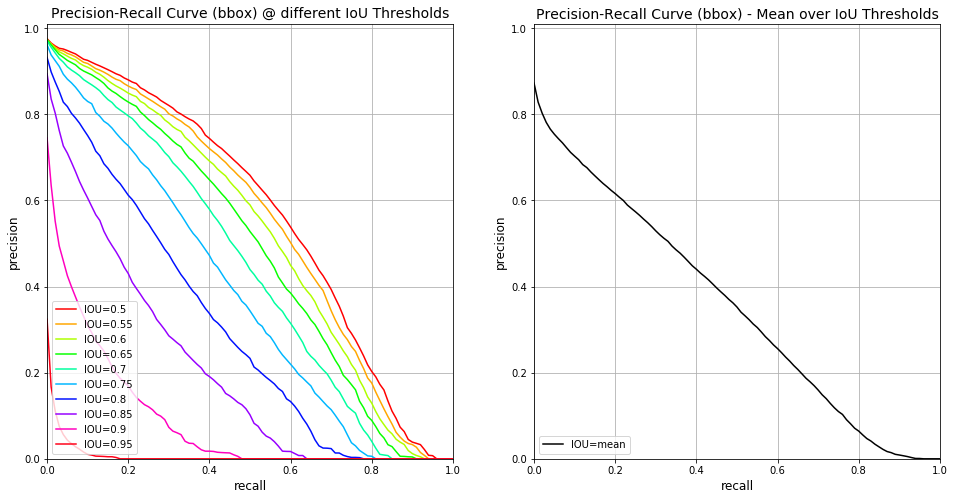

In [11]:
plot_pr_curves(e)

# Inference speed vs. accuracy

The remainder of this notebook is exploring the accuracy vs. inference speed trade-offs for various parameters. As quantitative measure we use the average precision (AP) at an IoU of 0.5. This corresponds to a relatively tight fit with ground truth object location and is sufficient for most real-world problems. Note that inference and training speed are strongly correlated and hence e.g. halving inference time roughly equates to halving training time.

In [12]:
# Loop over various parameters   
aps = []
for size in [200, 300]:
    print(f"\nTesting variable: size = {size}...")
       
    # Get model
    model = get_pretrained_fasterrcnn(
        min_size = size,
        max_size = size
    )
    detector = DetectionLearner(data, model)
    
    # Compute inference time
    start_time = time.time()
    detector.predict_dl(data.test_dl)
    inference_time = time.time() - start_time
    print(f"inference time = {inference_time:.2f} seconds")

    # Compute accuracy
    e = detector.evaluate()
    ap = _calculate_ap(e, iou_thres=0.5)
    aps.append(ap)
    print("At size = {} -> AP = {:.2f}".format(size, ap["bbox"]))


Testing variable: size = 100...
inference time = 139.17 seconds
creating index...
index created!
Test:  [   0/2500]  eta: 0:01:57  model_time: 0.0312 (0.0312)  evaluator_time: 0.0000 (0.0000)  time: 0.0469  data: 0.0156  max mem: 2170
Test:  [ 100/2500]  eta: 0:02:22  model_time: 0.0312 (0.0296)  evaluator_time: 0.0000 (0.0053)  time: 0.0604  data: 0.0228  max mem: 2170
Test:  [ 200/2500]  eta: 0:02:16  model_time: 0.0312 (0.0289)  evaluator_time: 0.0156 (0.0062)  time: 0.0595  data: 0.0211  max mem: 2170
Test:  [ 300/2500]  eta: 0:02:10  model_time: 0.0312 (0.0289)  evaluator_time: 0.0000 (0.0058)  time: 0.0603  data: 0.0266  max mem: 2170
Test:  [ 400/2500]  eta: 0:02:04  model_time: 0.0312 (0.0288)  evaluator_time: 0.0000 (0.0059)  time: 0.0620  data: 0.0275  max mem: 2170
Test:  [ 500/2500]  eta: 0:01:58  model_time: 0.0312 (0.0288)  evaluator_time: 0.0000 (0.0058)  time: 0.0587  data: 0.0219  max mem: 2170
Test:  [ 600/2500]  eta: 0:01:52  model_time: 0.0312 (0.0288)  evaluator_t

### Observations

If not otherwise specified, we use the default parameters stated in `get_pretrained_fasterrcnn()` with batch size of 2, running on an Azure Linux DSVM with single V100 GPU. Using these default parameters, the AP is `0.57` at an inference time of `46.1` ms per image. On an near-identical Windows DSVM, the inference speed would be `66.4` ms due to [PyTorch's dataloader being slow on Windows](https://github.com/pytorch/pytorch/issues/12831). Note that these speeds will differ depending on the exact machine configuration including especially the type of GPU.

The plot below summarizes the results of running multiple experiments; for an explanation of all parameters see Torchvision's [faster_rcnn.py](https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py#L50). We observe that:
- The parameters `box_detections_per_img`, `box_nms_thresh` and `box_score_thresh` do not effect inference speed and hence are omitted from the plot. 
- Image resolution has the biggest influence on inference speed however at the cost of significantly reducing accuracy.
- Using less than the default 1000 region proposals can lead to slightly faster but less accurate models.  

By combining these findings, we can define a sweet-spot for COCO at `min_size = max_size = 750` and `rpn_pre_nms_top_n_test = rpn_post_nms_top_n_test = 250` of `0.52` AP at `24.5` ms per image. Increasing the `batch_size` to 8 improves the inference time only modestly to `23.1` ms. 

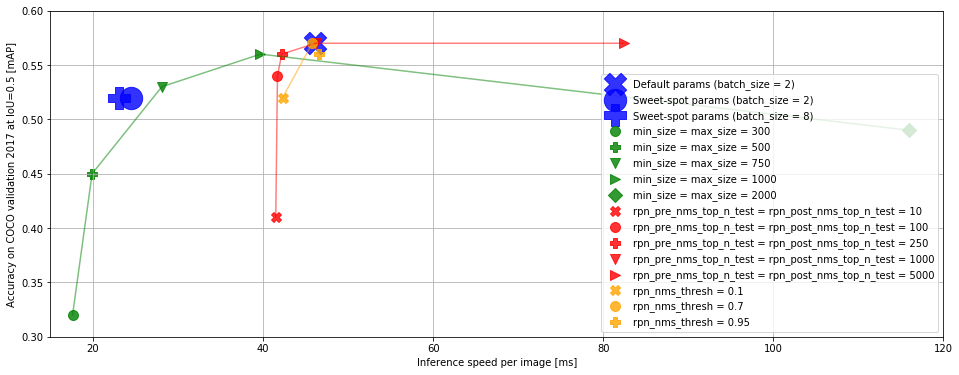

In [3]:
# Plot accuracy vs inference speed
colors = ("green", "red", "orange", "blue", "black")
markers = ('X', 'o', 'P', 'v', '>', 'D')
plt.figure(figsize=(16,6))
plt.scatter(46.1, 0.57, c=colors[3], marker=markers[0], s=500, alpha=0.8, label="Default params (batch_size = 2)") 
plt.scatter(24.5, 0.52, c=colors[3], marker=markers[1], s=500, alpha=0.8, label="Sweet-spot params (batch_size = 2)") 
plt.scatter(23.1, 0.52, c=colors[3], marker=markers[2], s=500, alpha=0.8, label="Sweet-spot params (batch_size = 8)")
plt.plot([17.6,19.9,28.1,39.7,116.], [0.32,0.45,0.53,0.56,0.49], c=colors[0], alpha=0.5)
plt.scatter(17.6, 0.32, c=colors[0], marker=markers[1], s=100, alpha=0.8, label="min_size = max_size = 300") 
plt.scatter(19.9, 0.45, c=colors[0], marker=markers[2], s=100, alpha=0.8, label="min_size = max_size = 500") 
plt.scatter(28.1, 0.53, c=colors[0], marker=markers[3], s=100, alpha=0.8, label="min_size = max_size = 750") 
plt.scatter(39.7, 0.56, c=colors[0], marker=markers[4], s=100, alpha=0.8, label="min_size = max_size = 1000")
plt.scatter(116., 0.49, c=colors[0], marker=markers[5], s=100, alpha=0.8, label="min_size = max_size = 2000")
plt.plot([41.5,41.7,42.2,46.2,82.4], [0.41,0.54,0.56,0.57,0.57], c=colors[1], alpha=0.5)
plt.scatter(41.5, 0.41, c=colors[1], marker=markers[0], s=100, alpha=0.8, label="rpn_pre_nms_top_n_test = rpn_post_nms_top_n_test = 10") 
plt.scatter(41.7, 0.54, c=colors[1], marker=markers[1], s=100, alpha=0.8, label="rpn_pre_nms_top_n_test = rpn_post_nms_top_n_test = 100")
plt.scatter(42.2, 0.56, c=colors[1], marker=markers[2], s=100, alpha=0.8, label="rpn_pre_nms_top_n_test = rpn_post_nms_top_n_test = 250")
plt.scatter(46.2, 0.57, c=colors[1], marker=markers[3], s=100, alpha=0.8, label="rpn_pre_nms_top_n_test = rpn_post_nms_top_n_test = 1000") 
plt.scatter(82.4, 0.57, c=colors[1], marker=markers[4], s=100, alpha=0.8, label="rpn_pre_nms_top_n_test = rpn_post_nms_top_n_test = 5000")
plt.plot([42.3,45.8,46.6], [0.52,0.57,0.56], c=colors[2], alpha=0.5)
plt.scatter(42.3, 0.52, c=colors[2], marker=markers[0], s=100, alpha=0.8, label="rpn_nms_thresh = 0.1") 
plt.scatter(45.8, 0.57, c=colors[2], marker=markers[1], s=100, alpha=0.8, label="rpn_nms_thresh = 0.7") 
plt.scatter(46.6, 0.56, c=colors[2], marker=markers[2], s=100, alpha=0.8, label="rpn_nms_thresh = 0.95") 
plt.grid()
plt.xlim(15, 120)
plt.ylim(0.3, 0.6)
plt.xlabel("Inference speed per image [ms]")
plt.ylabel("Accuracy on COCO validation 2017 at IoU=0.5 [mAP]")
plt.legend(loc=4)
plt.show()

# Conclusion

This notebook illustrated the trade-off between inference time and accuracy induced by different parameter settings and using COCO as benchmark dataset. Additionally, it was shown how to reproduce the accuracy of Torchvision's pre-trained Faster R-CNN model as published on their [models](https://pytorch.org/docs/stable/torchvision/models.html) site.

In [14]:
# Preserve some of the notebook outputs
sb.glue("aps", aps)
sb.glue("num_test_images", len(data.test_ds))